In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [3]:
directory = '/home/choudhar/HNNs/data/'
folder = "henon_heiles_filt/"
dynamics = "henon_heiles"

In [4]:
train_file_path = directory + folder + dynamics+"_train.pt"
val_file_path = directory + folder + dynamics+"_val.pt"
test_file_path = directory + folder + dynamics+"_test.pt"
noisy_train_file_path = directory + folder + "noisy_" + dynamics + "_train_1.pt"
noisy_val_file_path = directory + folder + "noisy_" + dynamics + "_val_1.pt"
noisy_test_file_path = directory + folder + "noisy_" + dynamics + "_test_1.pt"


In [5]:
train_noisy = torch.load(noisy_train_file_path)
val_noisy = torch.load(noisy_val_file_path)
test_noisy = torch.load(noisy_val_file_path)

train = torch.load(train_file_path)
val = torch.load(val_file_path)
test = torch.load(val_file_path)

In [6]:
def henon_heiles(y, args, kargs):
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    
    dq1 = p1
    dq2 = p2
    dp1 = -q1 - 2 * q1 * q2
    dp2 = -q2 - q1**2 + q2**2
    
    return torch.stack((dq1, dq2, dp1, dp2), dim=-1)

In [7]:
def forward_ode(y_tensor, args, kargs):

    model = args[0]
    i = kargs[0]
        
    with torch.enable_grad():

        y = y_tensor.clone().detach().requires_grad_(True)

        h = model(y)

    
        grad_h = torch.autograd.grad(outputs=h.sum(), inputs=y, create_graph=True, retain_graph=True, allow_unused=True)[0]
        #print("grad h: ", grad_h)
        dq1_dt = grad_h[:, 2]
        dq2_dt = grad_h[:, 3]
        dp1_dt = -grad_h[:, 0]
        dp2_dt = -grad_h[:, 1]

    return torch.stack((dq1_dt, dq2_dt, dp1_dt, dp2_dt), dim=-1)

In [8]:
import torch.nn as nn

class HamiltonianNN(nn.Module):

    # For now the input data is passed as init parameters
    def __init__(self, model_specs):
        super(HamiltonianNN, self).__init__()

        # Create a list of linear layers based on layer_sizes
        layer_sizes = model_specs[0]
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.RANDOM_SEED = 0
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

            if i < len(layer_sizes) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if i < len(self.batch_norms):
                x = self.batch_norms[i](x)
            #x = x.requires_grad_(True)
            x = torch.sigmoid(x)
        x = ((self.layers[-1](x)))
        return x/32.

In [9]:
def get_dynamics_plot(y, model, dynamics):
    
    pred_dyn = forward_ode(y, (model,), (0,))
    true_dyn = dynamics(y, None, None)
    return pred_dyn, true_dyn

In [10]:
def rk2_step(dyn, y, dt, dynamics, args, kargs):
    h = dt
    i = kargs[0]
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]

    dy1 = dynamics(y, args, kargs)
    q1_1 = q1 + 0.5 * dy1[:, 0] * h
    q2_1 = q2 + 0.5 * dy1[:, 1] * h
    p1_1 = p1 + 0.5 * dy1[:, 2] * h
    p2_1 = p2 + 0.5 * dy1[:, 3] * h

    y1 = torch.stack((q1_1, q2_1, p1_1, p2_1), dim=-1)
    dy2 = dynamics(y1, args, kargs)

    q1_new = q1 + dy2[:, 0] * h
    q2_new = q2 + dy2[:, 1] * h
    p1_new = p1 + dy2[:, 2] * h
    p2_new = p2 + dy2[:, 3] * h
    
    return torch.stack((q1_new, q2_new, p1_new, p2_new), dim=-1)


def sv_step(dyn, y, dt, dynamics, iterations, y_init, args, kargs):
    h = dt
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    i = kargs[0]

    p1_half = p1 + 0.5 * h * dynamics(torch.stack((q1, q2, y_init[:, 2], y_init[:, 3]), dim=-1), args, kargs)[:, 2]
    p2_half = p2 + 0.5 * h * dynamics(torch.stack((q1, q2, y_init[:, 2], y_init[:, 3]), dim=-1), args, kargs)[:, 3]
    
    for _ in range(iterations):
        p1_half = p1 + 0.5 * h * dynamics(torch.stack((q1, q2, p1_half, p2_half), dim=-1), args, kargs)[:, 2]
        p2_half = p2 + 0.5 * h * dynamics(torch.stack((q1, q2, p1_half, p2_half), dim=-1), args, kargs)[:, 3]

    q1_half = q1 + 0.5 * h * dynamics(torch.stack((y_init[:, 0], y_init[:, 1], p1_half, p2_half), dim=-1), args, kargs)[:, 0]
    q2_half = q2 + 0.5 * h * dynamics(torch.stack((y_init[:, 0], y_init[:, 1], p1_half, p2_half), dim=-1), args, kargs)[:, 1]
    
    for _ in range(iterations):
        q1_half = q1 + 0.5 * h * dynamics(torch.stack((q1_half, q2_half, p1, p2), dim=-1), args, kargs)[:, 0]
        q2_half = q2 + 0.5 * h * dynamics(torch.stack((q1_half, q2_half, p1, p2), dim=-1), args, kargs)[:, 1]

    q1_new = q1 + h * dynamics(torch.stack((q1_half, q2_half, p1_half, p2_half), dim=-1), args, kargs)[:, 0]
    q2_new = q2 + h * dynamics(torch.stack((q1_half, q2_half, p1_half, p2_half), dim=-1), args, kargs)[:, 1]
    p1_new = p1_half + 0.5 * h * dynamics(torch.stack((q1_new, q2_new, p1_half, p2_half), dim=-1), args, kargs)[:, 2]
    p2_new = p2_half + 0.5 * h * dynamics(torch.stack((q1_new, q2_new, p1_half, p2_half), dim=-1), args, kargs)[:, 3]

    return torch.stack((q1_new, q2_new, p1_new, p2_new), dim=-1)

In [11]:
def solve_ivp_custom_ms(dynamics, dyn, y_batch, t_span, dt, args, iters):
    #t = torch.arange(0, T, dt)
    batch_size = y_batch.shape[0]
    t0, t1 = t_span
    t = 0.1
    if t0 > t1:
        dt = -dt
    num_steps = int((t1 - t0) / t)
    #y0_batch = noisy_obs[:, 0, :]
    ys_batch = []
    #print(y0_batch.shape)
    #print("y len: ",y_batch.shape[1])
    #_y = torch.zeros((batch_size, t_vals.shape[0], 2), dtype=torch.float32, requires_grad=False, device=y_init.device)
    #_y[:, 0, :] = y_init.clone()

    for i in range(0, num_steps):
        if i == 0:
            y = y_batch[:,0,:]
            #y.requires_grad_(True)
            ys_batch.append(y)
        else:
            y = y_batch[:,len(ys_batch)-1,:]
            #print("goes in: ", len(ys_batch)-1)
            #y.requires_grad_(True)
            ys_batch[-1] = y
        for j in range(1, int(t/dt)+1):
            #y = noisy_obs[:, i-1, :]  # Use the noisy observation at the current step
            y = ys_batch[-1]
            y_ = rk2_step(dyn, y, dt, dynamics, args, kargs=(j,))
            y_next = sv_step(dyn, y, dt, dynamics, iters, y_, args, kargs=(j,))
            #print(y_next.requires_grad)
            ys_batch.append(y_next)
        #print(y_next.shape)
    ys_batch = torch.stack(ys_batch, dim=1)
    #print(ys_batch.requires_grad)
    #print("return len: ", ys_batch.shape[1])
    return ys_batch

In [12]:
def gen_trajs(noisy_val_trajs, model):
    #pq0_batch = true_val_trajectories[0:128, 0, :]
    dt_solve=0.01
    #T=20.0
    T=10.0
    pq0_batch = noisy_val_trajs[0:20, :, :]
    y_pred_batch = solve_ivp_custom_ms(forward_ode, "forward", pq0_batch, (0, T), dt_solve, args=(model,), iters=5)
    return y_pred_batch

In [13]:
# Load the model
#model = torch.load('/home/choudhar/HNNs/models/model_0_ms.pt')
model = torch.load('/home/choudhar/HNNs/models/model_0_hh_adjoint.pt')
#model = torch.load('/home/choudhar/HNNs/models/model_0_ns.pt')
model.eval()  # Set the model to evaluation mode


HamiltonianNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
  (layer_norms): ModuleList()
  (batch_norms): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [13]:
pred_trajs = gen_trajs(test_noisy, model)

KeyboardInterrupt: 

In [14]:
h = torch.zeros((6, test_noisy.shape[1]))
p_0_x = test_noisy[0:6, 0, 2]
q_0_x = test_noisy[0:6, 0, 0]
p_0_y = test_noisy[0:6, 0, 3]
q_0_y = test_noisy[0:6, 0, 1]

#h_0 = (0.5*p_0**2) + (0.5*q_0**2)
#h_0 = (0.5*(p_0**2) + 0.25*(q_0**4) - 0.5*(q_0**2))
h_0 = (0.5*(p_0_x**2 + p_0_y**2) + (0.5*(q_0_x**2 + q_0_y**2)) + ((q_0_x**2)*q_0_y) - ((q_0_y**3)/3))
#h_0 = (0.5*q_0**2) + (q_0*p_0**2) + (0.5*p_0**2) - (0.25*p_0**4)
for i in range(test_noisy.shape[1]):
    pred_h = model(test_noisy[0:6,i,:]).squeeze()
    offset = pred_h - h_0
    h[:, i] = pred_h - offset

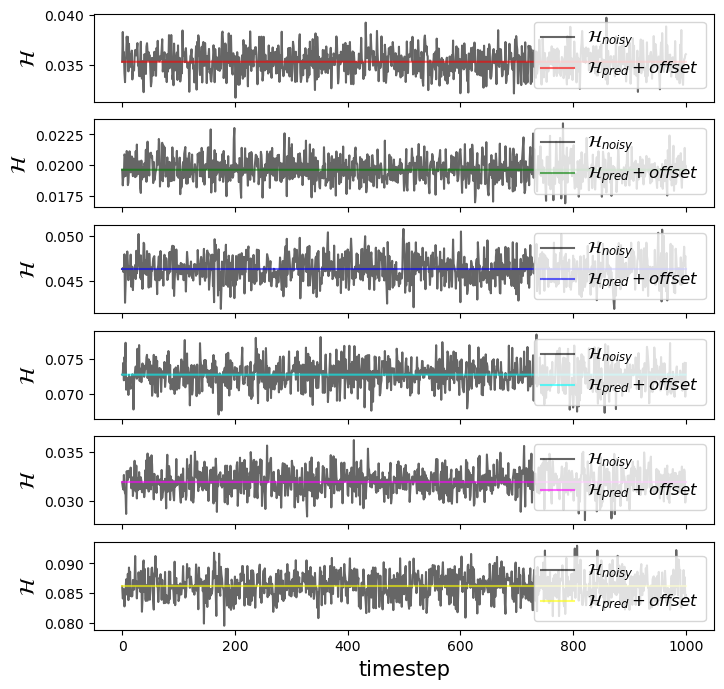

In [15]:
def create_subplots(h1, h2):

  num_subplots = 6
  fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 8), sharex=True)

  colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']

  for i in range(num_subplots):
    axes[i].plot(np.arange(h.shape[1]), h2[i,:], color='black', alpha=0.6, label='$\mathcal{H}_{noisy}$')
    axes[i].plot(np.arange(h.shape[1]), h1[i,:], color=colors[i], alpha=0.6, label='$\mathcal{H}_{pred} + offset$')
    axes[i].set_ylabel("$\mathcal{H}$", fontsize=15)
    axes[i].legend(fontsize=12)
  axes[5].set_xlabel("timestep", fontsize=15)

  plt.show()

# Example usage:
# Replace h1 and h2 with your actual data
#h1 = np.random.rand(6, 100)
#h2 = np.random.rand(6, 100)
p_t_x = test_noisy[0:6, :, 2]
p_t_y = test_noisy[0:6, :, 3]
q_t_x = test_noisy[0:6, :, 0]
q_t_y = test_noisy[0:6, :, 1]
#h_t = (0.5*p_t**2) + (0.5*q_t**2)
h_t = (0.5*(p_t_x**2 + p_t_y**2) + (0.5*(q_t_x**2 + q_t_y**2)) + ((q_t_x**2)*q_t_y) - ((q_t_y**3)/3))
#h_t = (0.5*q_t**2) + (q_t*p_t**2) + (0.5*p_t**2) - (0.25*p_t**4) 
create_subplots(h.detach().numpy(), h_t)

In [14]:
pred_dyn, true_dyn = get_dynamics_plot(test_noisy[:, 0, :], model, henon_heiles)
pred_dyn_fut, true_dyn_fut = get_dynamics_plot(test_noisy[:, 100, :], model, henon_heiles)

In [15]:
pred_dyn_np = pred_dyn.detach().numpy()
pred_dyn_np_fut = pred_dyn_fut.detach().numpy()

In [16]:
plot_res = (torch.abs(pred_dyn[:, 0] - true_dyn[:, 0]) + torch.abs(pred_dyn[:, 2] - true_dyn[:, 2]) + torch.abs(pred_dyn[:, 1] - true_dyn[:, 1]) + torch.abs(pred_dyn[:, 3] - true_dyn[:, 3]))
plot_res_fut = (torch.abs(pred_dyn_fut[:, 0] - true_dyn_fut[:, 0]) + torch.abs(pred_dyn_fut[:, 2] - true_dyn_fut[:, 2]))
sup_norm_1 = torch.max(pred_dyn[:, 0] - true_dyn[:, 0])
sup_norm_2 = torch.max(pred_dyn[:, 2] - true_dyn[:, 2])

In [17]:
plot_res.shape
plot_res_np = plot_res.detach().numpy()
plot_res_fut_np = plot_res_fut.detach().numpy()

/tmp/ipykernel_222044/1426024288.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(plot_res_np, shade=True, label="t=0 sec")


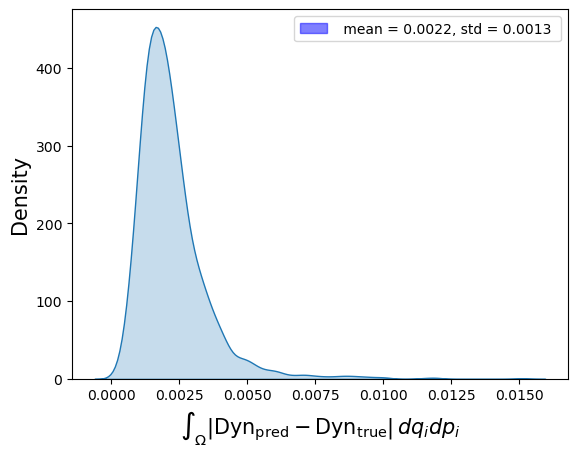

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Generate some random data
np.random.seed(0)
#data = np.random.randn(1000)  # 1000 samples from a normal distribution

# Plot the KDE
sns.kdeplot(plot_res_np, shade=True, label="t=0 sec")
#sns.kdeplot(plot_res_fut_np, shade=True, label="t=1 sec")

# Adding labels and title
plt.xlabel(r'$\int_{\Omega} \left| \mathrm{Dyn_{pred}} - \mathrm{Dyn_{true}} \right| \, dq_i dp_i$', fontsize=15)
plt.ylabel('Density', fontsize=15)
# plt.legend(title=r'(t=0sec)$ mean = {:.4f}, std = {:.4f} $'.format(np.mean(plot_res_np), (np.std(plot_res_np))))
# plt.legend(title=r'(t=1sec)$ mean = {:.4f}, std = {:.4f} $'.format(np.mean(plot_res_fut_np), (np.std(plot_res_fut_np))))

legend_handles = [
    Patch(color='blue', alpha=0.5, label=r' mean = {:.4f}, std = {:.4f} '.format(np.mean(plot_res_np), np.std(plot_res_np))),
    #Patch(color='orange', alpha=0.5, label=r'(t=1) mean = {:.4f}, std = {:.4f} '.format(np.mean(plot_res_fut_np), np.std(plot_res_fut_np)))
]
plt.legend(handles=legend_handles)
# Show the plot
plt.show()

In [38]:
eval_traj = 18

In [19]:
eval_traj_2 = 10

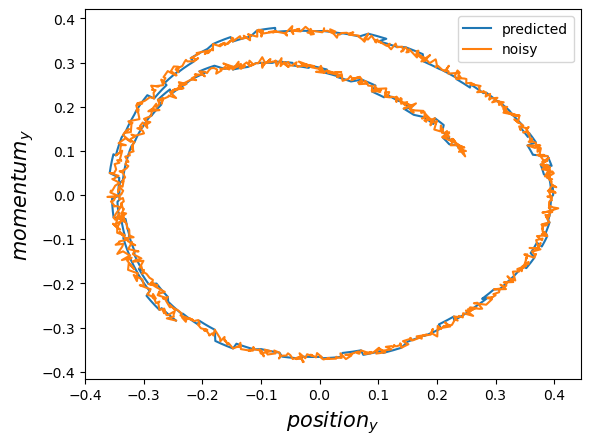

In [55]:
plt.plot(pred_trajs[eval_traj,:,1].detach().numpy(), pred_trajs[eval_traj,:,3].detach().numpy(), label='predicted')
plt.plot(test_noisy[eval_traj,:,1], test_noisy[eval_traj,:,3], label='noisy')
plt.xlabel('$position_y$', fontsize=15)
plt.ylabel('$momentum_y$', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right')

In [40]:
fut_pt = 0
pred_dyn_fut, true_dyn_fut = get_dynamics_plot(test_noisy[:, fut_pt, :], model, henon_heiles)
pred_dyn_np_fut = pred_dyn_fut.detach().numpy()

In [26]:
pred_dyn_np_fut[0:10,:]

array([[ 0.12578295, -0.23097955, -0.01359388, -0.03487209],
       [-0.03638957, -0.19178954, -0.02507355,  0.00414547],
       [-0.24764886, -0.07956503, -0.04568362,  0.1580113 ],
       [-0.17651254, -0.22377047,  0.23503797, -0.16268557],
       [-0.18639457,  0.10116566, -0.04960349,  0.12918119],
       [ 0.05892297, -0.17365515, -0.3883998 , -0.22794956],
       [-0.28192198,  0.0315567 ,  0.1650347 ,  0.18258497],
       [ 0.10280841,  0.14745891,  0.10619505, -0.01789355],
       [ 0.1788289 , -0.22018108,  0.3099712 , -0.20510451],
       [ 0.13713294, -0.2501014 ,  0.24573444, -0.09243044]],
      dtype=float32)

In [35]:
true_dyn_fut[0:10,:]

tensor([[ 0.2107,  0.0636, -0.2157,  0.0720],
        [-0.1335, -0.2677,  0.0297,  0.3065],
        [ 0.2199, -0.0972, -0.2120, -0.1771],
        [-0.0066, -0.0143, -0.0125, -0.1087],
        [ 0.2021, -0.2685,  0.0169,  0.2409],
        [-0.2407, -0.1677, -0.0328,  0.3496],
        [-0.2488, -0.1204, -0.0766,  0.1259],
        [-0.0601,  0.1015, -0.0691,  0.0771],
        [ 0.1635, -0.2410,  0.1760, -0.0872],
        [ 0.1666, -0.2468,  0.1343, -0.0105]])

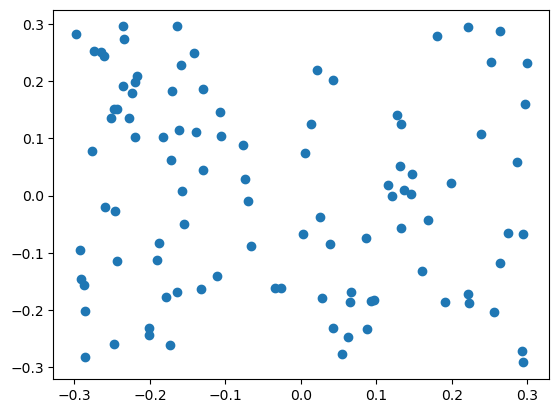

In [43]:
plt.scatter(test_noisy[0:100, 0, 0], test_noisy[0:100, 0, 2])

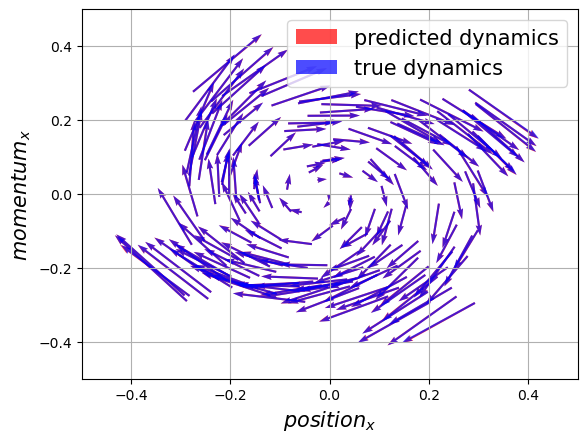

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Example vectors
#a = np.array([1, 2, 3])
#b = np.array([4, 5, 6])
num_pts = 200

# Create a figure and axis
fig, ax = plt.subplots()

# Plot arrows using quiver
# a, b are the starting points, and a, b are the directions
ax.quiver(test_noisy[0:num_pts, fut_pt, 1], test_noisy[0:num_pts, fut_pt, 3], pred_dyn_np_fut[0:num_pts, 1], pred_dyn_np_fut[0:num_pts, 3] , angles='xy', scale_units='xy', scale=2, color='r', label="predicted dynamics", alpha =0.7)
ax.quiver(test_noisy[0:num_pts, fut_pt, 1], test_noisy[0:num_pts, fut_pt, 3], true_dyn[0:num_pts, 1], true_dyn[0:num_pts, 3], angles='xy', scale_units='xy', scale=2, color='b', label="true dynamics", alpha =0.7)

# Set the limits of the plot
ax.set_xlim(-0.5,  0.5)
ax.set_ylim(-0.5, 0.5)

# Adding labels and title
#plt.title('Arrows Plot')
plt.xlabel('$position_y$', fontsize=15)
plt.ylabel('$momentum_y$', fontsize=15)

# Show grid
plt.grid(True)
plt.legend(fontsize=15)

# Show the plot
plt.show()

In [44]:
abbr = 'hh'

In [48]:
df = pd.read_csv('/home/choudhar/HNNs/gpu_scripts/output_0_'+abbr+'_more_n.csv')

In [49]:
arr = df.values

Text(0, 0.5, 'Loss')

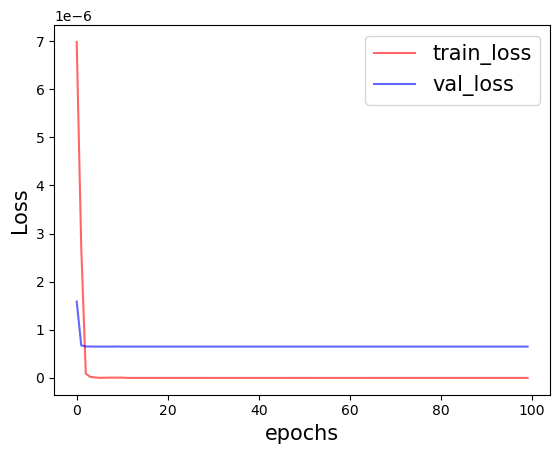

In [50]:
plt.plot(arr[:,0], label = 'train_loss', c='r', alpha=0.6)
plt.plot(arr[:,1], label = 'val_loss', c='b', alpha=0.6)
plt.legend(fontsize=15)
plt.ticklabel_format(axis='y', style='sci')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

Text(0, 0.5, 'Y coordinate')

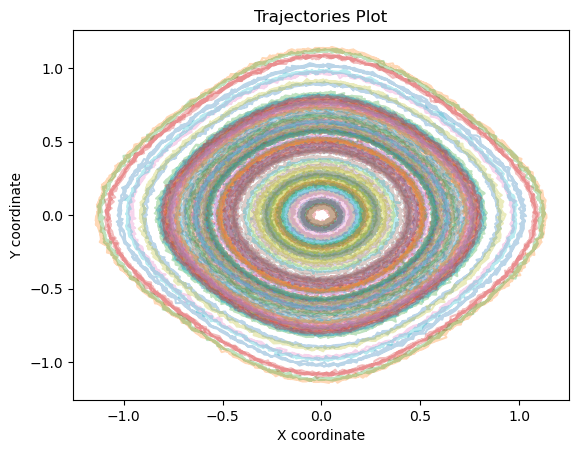

In [65]:
# Create a figure and axis
fig, ax = plt.subplots()

# Loop through each case along dimension 0 and plot the trajectory
for i in range(100):
    ax.plot(test_noisy[i, :, 0], test_noisy[i, :, 1], alpha=0.3)  # alpha for transparency

# Adding labels and title
plt.title('Trajectories Plot')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')